In [24]:
import os
import pickle
from scipy import signal
import libfmp.b
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelmin, argrelmax
from pydub import AudioSegment
from scipy.signal import find_peaks
from pydub.generators import Triangle

from compute_tempo import *

In [2]:
nn = 2
mvnfiles = ["BKO_E1_D1_01_Suku_T.mvnx", "BKO_E1_D1_02_Maraka_T.mvnx", "BKO_E1_D1_03_Wasulunka_T.mvnx", "BKO_E1_D2_04_Maraka_T.mvnx"]
# annotation = ["BKO_E1_D1_01_Suku_Dancers.csv", "BKO_E1_D1_02_Maraka_Dancers.csv", "BKO_E1_D1_03_Wasulunka_Dancers.csv", "BKO_E1_D2_04_Maraka.csv"]
# cyclefile= ["BKO_E1_D1_01_Suku_C.csv", "BKO_E1_D1_02_Maraka_C.csv", "BKO_E1_D1_03_Wasulunka_C.csv", "BKO_E1_D2_04_Maraka_C.csv"]


file_path = f"./mocap_mvnx/{mvnfiles[nn]}"
file_name = os.path.basename(file_path).split(".")[0]

# djembe_obj = djembe(file_path)
# motion_data, _, _, _ = djembe_obj.load_djembe(frme=-1)

pickle_path = f'./output/motion_data_pkl/{file_name}.pkl'
    
if os.path.isfile(pickle_path):
    with open(pickle_path, 'rb') as file:
        motion_data = pickle.load(file)
    print(f"Loaded {file_name}.pkl")

# save_path = f'./output/motion_data/motion_data_{file_name}.pkl'
# if not os.path.exists(save_path):
#     with open(save_path, 'wb') as f:
#         pickle.dump(motion_data, f)

Loaded BKO_E1_D1_03_Wasulunka_T.pkl


In [ ]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT

righthand_segname = 'SEGMENT_RIGHT_HAND'
lefthand_segname = 'SEGMENT_LEFT_HAND'

righthand_velocity = motion_data['velocity'][righthand_segname] # size (n, 3)
lefthand_velocity = motion_data['velocity'][lefthand_segname]   # size (n, 3)

novelty_length = len(righthand_velocity)
time_axis = np.arange(novelty_length)/240

mocap_fps = 240
window_size = 240*5 #corresponding to 10 sec
hop_size = 10
tempi_range = np.arange(60,240,10)


tempo_json_two_sensor = main_two_sensor(righthand_velocity, lefthand_velocity, mocap_fps, window_size, hop_size, tempi_range)
# tempo_json_one_sensor = main_one_sensor(pelvis_velocity, mocap_fps, window_size, hop_size, tempi_range)

sensorA_dir_change_onsets = tempo_json_two_sensor["sensorA_dir_change_onsets"]
sensorB_dir_change_onsets = tempo_json_two_sensor["sensorB_dir_change_onsets"]
filteredcombined_sensor_onsets = tempo_json_two_sensor["filteredcombined_sensor_onsets"]

tempogram_ab = tempo_json_two_sensor["tempogram_ab"]
time_axis_seconds = tempo_json_two_sensor["time_axis_seconds"]
tempo_axis_bpm = tempo_json_two_sensor["tempo_axis_bpm"]

tempo_data_maxmethod = tempo_json_two_sensor["tempo_data_maxmethod"]
tempo_data_weightedkernel = tempo_json_two_sensor["tempo_data_weightedkernel"]
tempo_data_combinedtempogram = tempo_json_two_sensor["tempo_data_combinedtempogram"]

# # Max method
# Aestimated_beat_pulse = tempo_data_maxmethod["estimated_beat_pulse"]
# Atempo_curve = tempo_data_maxmethod["tempo_curve"]
# Atempo_curve_time_axis = tempo_data_maxmethod["tempo_curve_time_axis"]
# Aglobal_tempo_bpm = tempo_data_maxmethod["global_tempo_bpm"]

# # Weighted method
# Bestimated_beat_pulse = tempo_data_weightedkernel["estimated_beat_pulse"]
# Btempo_curve = tempo_data_weightedkernel["tempo_curve"]
# Btempo_curve_time_axis = tempo_data_weightedkernel["tempo_curve_time_axis"]
# Bglobal_tempo_bpm = tempo_data_weightedkernel["global_tempo_bpm"]

# # Combined method
# Cestimated_beat_pulse = tempo_data_combinedtempogram["estimated_beat_pulse"]
# Ctempo_curve = tempo_data_combinedtempogram["tempo_curve"]
# Ctempo_curve_time_axis = tempo_data_combinedtempogram["tempo_curve_time_axis"]
# Cglobal_tempo_bpm = tempo_data_combinedtempogram["global_tempo_bpm"]

In [62]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT

mocap_fps = 240
window_size = 240*5 #corresponding to 10 sec SEGMENT_PELVIS
hop_size = 10
tempi_range = np.arange(60,240,10)

pelvis_velocity = motion_data['velocity']["SEGMENT_PELVIS"]

novelty_length = len(pelvis_velocity)
time_axis = np.arange(novelty_length)/240


tempo_json_one_sensor = main_one_sensor(pelvis_velocity, mocap_fps, window_size, hop_size, tempi_range)

# tempogram_ab = tempo_json_one_sensor["tempogram_ab"]
# time_axis_seconds = tempo_json_one_sensor["time_axis_seconds"]
# tempo_axis_bpm = tempo_json_one_sensor["tempo_axis_bpm"]

# tempo_data_maxmethod = tempo_json_one_sensor["tempo_data_maxmethod"]
# tempo_data_weightedkernel = tempo_json_one_sensor["tempo_data_weightedkernel"]
# tempo_data_combinedtempogram = tempo_json_one_sensor["tempo_data_combinedtempogram"]

# Cestimated_beat_pulse = tempo_data_combinedtempogram["estimated_beat_pulse"]
# Ctempo_curve = tempo_data_combinedtempogram["tempo_curve"]
# Ctempo_curve_time_axis = tempo_data_combinedtempogram["tempo_curve_time_axis"]
# Cglobal_tempo_bpm = tempo_data_combinedtempogram["global_tempo_bpm"]

Tempograms generated
Global Bpm: 152.61550962118508
Global Bpm: 152.62866289091357
Global Bpm: 125.96673519888706


In [44]:
X = librosa.stft(pelvis_velocity[:,0], n_fft=window_size, hop_length=hop_size, win_length=window_size, window='hann')
freq_stft = np.fft.rfftfreq(window_size, d=1/240)
time_stft = np.arange(X.shape[1]) * hop_size / 240



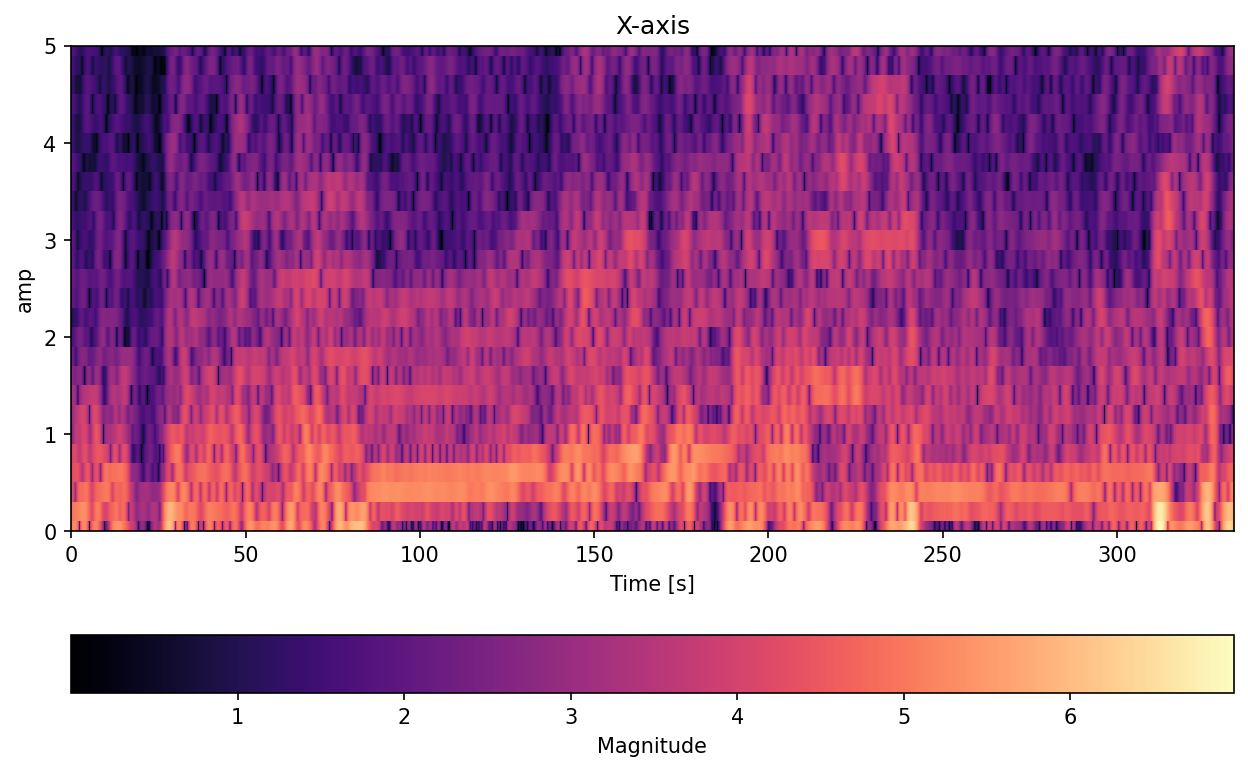

In [ ]:
Y = np.abs(X)
gamma = 2
Y = np.log(1 + gamma * np.abs(X))



plt.figure(figsize=(10, 6), dpi=150)
cax = plt.pcolormesh(time_stft, freq_stft, Y, shading='auto', cmap='magma')
plt.title('X-axis')
plt.xlabel('Time [s]')
plt.ylabel('amp')
plt.ylim(0,5)
plt.colorbar(cax, orientation='horizontal', label='Magnitude')
plt.show()

In [20]:
tempogram_ab, tempogram_raw, time_axis_seconds, tempo_axis_bpm = compute_tempogram_fourier(pelvis_velocity[240*80:240*140,:], mocap_fps, 
                                                                                           window_length=window_size, hop_size=hop_size, tempi=tempi_range)

Tempograms generated


In [64]:
def compute_local_average(x, M):
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average

In [ ]:
Y_diff = np.diff(Y, n=1)
Y_diff[Y_diff < 0] = 0
nov = np.sum(Y_diff, axis=0)
nov = np.concatenate((nov, np.array([0])))

M_sec = 0.1
M = int(np.ceil(M_sec * 240/hop_size))

local_average = compute_local_average(nov, M)
nov_norm =  nov - local_average
nov_norm[nov_norm<0]=0
nov_norm = nov_norm / max(nov_norm)


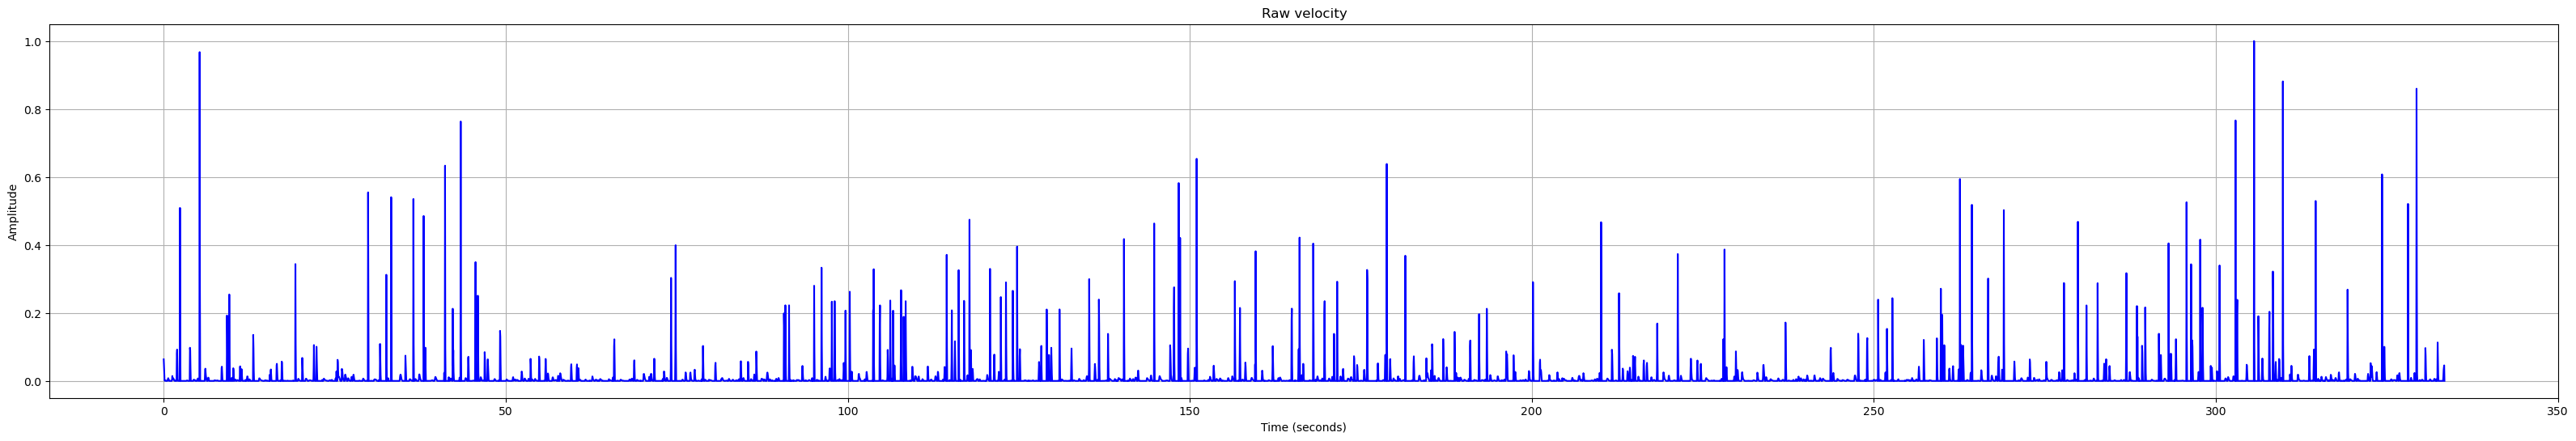

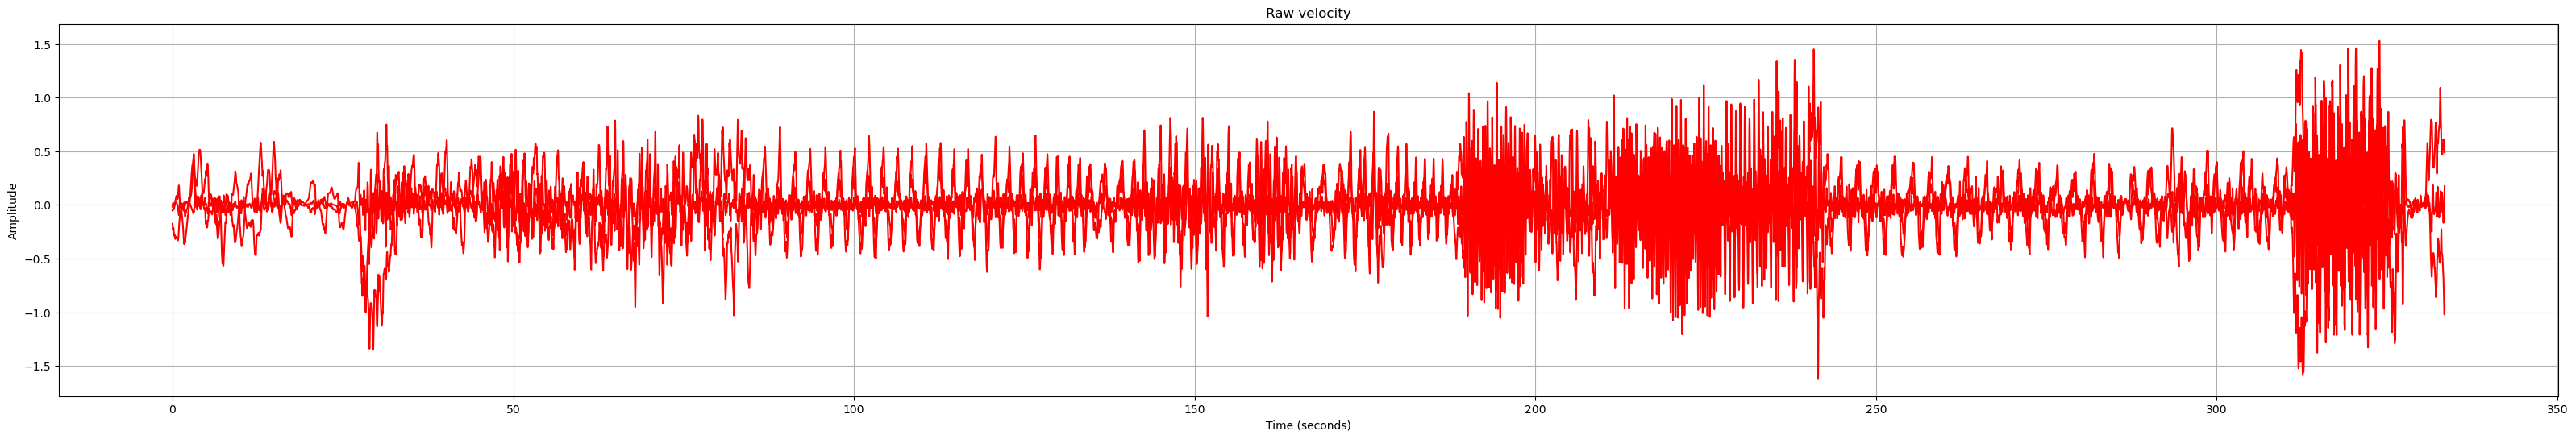

In [66]:
# tt = np.linspace(0, len(Ctempo_curve)/240, len(Ctempo_curve))


plt.figure(figsize=(40, 6))
plt.plot(time_stft, nov_norm, color = 'blue')
# plt.plot(time_axis[240*80:240*140], pelvis_velocity[240*80:240*140, 0], color = 'red')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Raw velocity')
plt.grid(True)
plt.show()

plt.figure(figsize=(40, 6))

plt.plot(time_axis, pelvis_velocity, color = 'red')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Raw velocity')
plt.grid(True)
plt.show()

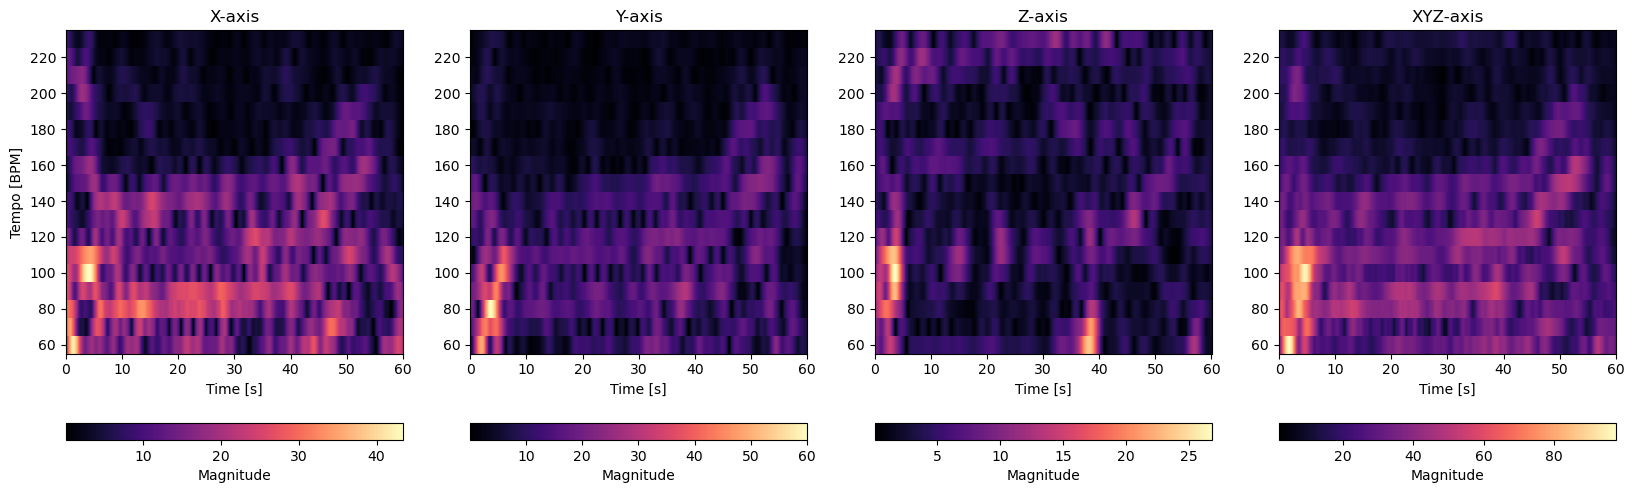

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(20,6), sharey=False)

# Tempogram X
cax1 = axs[0].pcolormesh(time_axis_seconds, tempo_axis_bpm, tempogram_ab[0], shading='auto', cmap='magma')
axs[0].set_title('X-axis')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Tempo [BPM]')
plt.colorbar(cax1, ax=axs[0], orientation='horizontal', label='Magnitude')

# Tempogram Y
cax2 = axs[1].pcolormesh(time_axis_seconds, tempo_axis_bpm, tempogram_ab[1], shading='auto', cmap='magma')
axs[1].set_title('Y-axis')
axs[1].set_xlabel('Time [s]')
plt.colorbar(cax2, ax=axs[1], orientation='horizontal', label='Magnitude')

# Tempogram Z
cax3 = axs[2].pcolormesh(time_axis_seconds, tempo_axis_bpm, tempogram_ab[2], shading='auto', cmap='magma')
axs[2].set_title('Z-axis')
axs[2].set_xlabel('Time [s]')
plt.colorbar(cax3, ax=axs[2], orientation='horizontal', label='Magnitude')

# Tempogram XYZ
cax3 = axs[3].pcolormesh(time_axis_seconds, tempo_axis_bpm, (tempogram_ab[0]+tempogram_ab[1]+tempogram_ab[2]), shading='auto', cmap='magma')
axs[3].set_title('XYZ-axis')
axs[3].set_xlabel('Time [s]')
plt.colorbar(cax3, ax=axs[3], orientation='horizontal', label='Magnitude')

# plt.suptitle(f'{segment_name} tempograms for the 3 axes')
plt.show()

In [ ]:
plt.figure(figsize=(40, 6), dpi=300)
plt.plot(time_axis, Cestimated_beat_pulse, linewidth=0.3, color = 'blue')
# plt.plot(Cestimated_beat_pulse, linewidth=0.3, color = 'red')


# plt.vlines(x=np.array([5, 10, 188, 241]), ymin=0.0, ymax=9, color='r', linestyle='dotted', linewidth=0.9)
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Beat Pulse')
plt.grid(True)
plt.show()

In [12]:
time = np.arange(novelty_length) / mocap_fps
peaks, properties = signal.find_peaks(Cestimated_beat_pulse)  # , prominence=0.02
beat_peaks_sec = time[peaks]

In [13]:
click_duration = 50  # milliseconds
click_freq = 1200  # Hz
file_name ="suku"
# Generate a single click sound
click = Triangle(click_freq).to_audio_segment(duration=click_duration)

onset_times = beat_peaks_sec  # kept_onsets/240
dN = novelty_length
total_duration = (dN/240)*1000  #  in milliseconds

audio = AudioSegment.silent(duration=total_duration)
for onset in onset_times:
    position = int(onset * 1000)  # Convert onset time to milliseconds
    audio = audio.overlay(click, position=position)

# Export the audio with clicks to a file
audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_Pelvis_combinedmethod_240.wav"), format="wav")

<_io.BufferedRandom name='/itf-fi-ml/home/sagardu/extract_feet_onset/suku_Pelvis_combinedmethod_240.wav'>